In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_feather("data/dataset_1k_more_feats.feather")
print(df.shape)

(1000, 397)


In [4]:
label_cols = ["kl_div_blowup_step", "plateau_length"]
# label_cols = ['kl_div_blowup_step']
exclude_cols = [
    "id",
    "start_prompt",
    "end_prompt",
    "perturbation_type",
    "final_kl_div",
    "perturbation_type",
    "kl_div_blowup_step",
    "plateau_length",
]
exclude_cols = set(exclude_cols) | set(label_cols)
feature_cols = [c for c in df.columns if c not in exclude_cols]

In [5]:
df[feature_cols].sample(5)

,prompts_cos_sim,prompts_token_sim,final_l2_norm,final_cos_sim,total_unique_active_features,avg_feature_activation_count,avg_active_features,std_active_features,avg_feature_activation,std_feature_activation,...,95_act_top_3_sae_feature_act,95_act_top_3_sae_feature_act_norm,95_act_top_3_sae_feature_sparsity,95_act_l2_norm,95_feat1_feat2_cos_sim,95_feat1_feat3_cos_sim,95_feat2_feat3_cos_sim,95_feat1_l0_inv_recon,95_feat2_l0_inv_recon,95_feat3_l0_inv_recon
381,0.760868,0.0,2.823501,0.820839,21,0.6271,13.17,1.456400,0.311961,0.029205,...,0.313865,0.08,0.090893,2.709420,0.9724,0.9688,0.9949,0,0,0
252,0.816582,0.2,2.615004,0.842988,14,0.9229,12.92,1.368795,0.407431,0.054555,...,0.594702,0.11,0.090893,2.509347,0.9175,0.9177,0.9949,1,0,0
423,0.751366,0.0,3.799510,0.703103,20,0.7115,14.23,1.056930,0.390593,0.043669,...,0.620096,0.10,0.119497,3.645995,0.9179,0.9169,0.9988,1,0,0
228,0.766295,0.1,2.258466,0.883438,18,0.6333,11.40,0.979796,0.391180,0.031567,...,0.604785,0.12,0.090893,2.167214,0.9375,0.9306,0.9910,2,0,0
22,0.750891,0.0,2.104737,0.899973,18,0.6017,10.83,0.938669,0.398854,0.032751,...,0.600157,0.12,0.090893,2.019697,0.9375,0.9306,0.9910,2,0,0


## Correlations

In [6]:
corr_df = df[feature_cols + label_cols].corr().filter(label_cols).drop(label_cols)
corr_df = corr_df.reset_index().rename(columns={"index": "feature"})

In [23]:
# corr_df.sort_values(by='kl_div_blowup_step', ascending=False).head(25)
corr_df[corr_df.feature.str.contains("cos", case=False)]

,feature,kl_div_blowup_step,plateau_length
0,prompts_cos_sim,0.029431,0.075990
3,final_cos_sim,0.275361,0.369216
23,0_feat1_feat2_cos_sim,0.174867,0.232753
24,0_feat1_feat3_cos_sim,0.222067,0.307868
25,0_feat2_feat3_cos_sim,0.041285,0.069384
...,...,...,...
366,90_feat1_feat3_cos_sim,-0.104791,-0.047497
367,90_feat2_feat3_cos_sim,-0.043940,-0.055769
384,95_feat1_feat2_cos_sim,-0.087341,-0.034611
385,95_feat1_feat3_cos_sim,-0.125256,-0.072873


In [22]:
# corr_df.sort_values(by=)

## Modelling

In [179]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import cupy as cp

In [180]:
X, y = df[feature_cols].to_numpy(), df[label_cols].to_numpy()

In [181]:
X.shape, y.shape

((1000, 390), (1000, 2))

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=52352
)

print(X_train.shape, X_test.shape)

(800, 390) (200, 390)


In [126]:
# # Comment out this block if you don't want to normalize
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Feature Selection

In [166]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=xgb.XGBRegressor(), threshold="median")
X_selected = selector.fit_transform(X_train, y_train)

In [167]:
X_selected.shape

(800, 135)

### Finding good hyperparams

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [55]:
param_dist = {
    "estimator__n_estimators": [100, 200, 300, 400, 500],
    "estimator__max_depth": [3, 5, 7, 8, 10],
    "estimator__learning_rate": [0.01, 0.05, 0.1, 0.2],
}

In [56]:
# Assuming X and y are your features and targets
X_sample, _, y_sample, _ = train_test_split(
    X_selected, y_train, train_size=0.1, random_state=42
)

# Convert your data to GPU
X_sample_gpu = cp.array(X_sample)
y_sample_gpu = cp.array(y_sample)

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=20, cv=3, n_jobs=-1
)
random_search.fit(X_sample_gpu, y_sample_gpu)
best_model = random_search.best_estimator_

/home/paperspace/virtualenvs/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/paperspace/virtualenvs/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/paperspace/virtualenvs/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/paperspace/virtualenvs/lib/python3.10/site-packages/sklearn/base.py", line 849, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/home/paperspace/virtualenvs/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/home/paperspace/virtualenvs/lib/python3.10/site-packages/sklearn

In [57]:
best_model

GPUMultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device='cuda',
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.01, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=10, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

In [53]:
import time

start_time = time.time()
model.fit(X_sample_gpu, y_sample_gpu)
end_time = time.time()

print(f"Single fit took {end_time - start_time} seconds")

Single fit took 15.75556492805481 seconds


### Training the models

In [183]:
import xgboost as xgb
import cupy as cp
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted


class GPUMultiOutputRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimator=None):
        self.estimator = estimator

    def fit(self, X, y):
        # Ensure y is 2D
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        self.n_outputs_ = y.shape[1]
        self.estimators_ = []

        for i in range(self.n_outputs_):
            # Create a new instance of the estimator for each output
            estimator = xgb.XGBRegressor(**self.estimator.get_params())
            estimator.fit(X, y[:, i])
            self.estimators_.append(estimator)

        return self

    def predict(self, X):
        check_is_fitted(self)

        # Predict for each estimator and stack the results
        preds = [cp.array(estimator.predict(X)) for estimator in self.estimators_]
        cupy_preds = cp.column_stack(preds)
        return cp.asnumpy(cupy_preds)

In [184]:
# Convert your data to GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)

In [192]:
reg_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    min_child_weight=2,
    subsample=0.5,
    colsample_bytree=0.8,
    # reg_alpha=0.5,
    # reg_lambda=0.5,
    gamma=0.1,
    random_state=42,
    device="cuda",
)
model = GPUMultiOutputRegressor(reg_model)

In [ ]:
# estimators = [
#     ('xgb', MultiOutputRegressor(xgb.XGBRegressor(n_jobs=-1))),
#     ('rf', MultiOutputRegressor(RandomForestRegressor(n_jobs=-1))),
#     ('ridge', MultiOutputRegressor(Ridge())),
#     ('svr', MultiOutputRegressor(SVR()))
# ]

# stacking_regressor = StackingRegressor(
#     estimators=estimators,
#     final_estimator=MultiOutputRegressor(LassoCV(n_jobs=-1)),
#     n_jobs=-1
# )

In [193]:
model.fit(X_train_gpu, y_train_gpu)

# Fit the model
# stacking_regressor.fit(X_selected, y_train)

GPUMultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.8,
                                               device='cuda',
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=0.1,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=10, max_leaves=None,
                                               min_child_weight=2, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

In [194]:
# X_test_selected = selector.transform(X_test)

X_test_gpu = cp.array(X_test)
y_pred = model.predict(X_test_gpu)

# X_test_gpu = cp.array(X_train)
# y_pred = model.predict(X_train_gpu)

# y_pred = stacking_regressor.predict(X_test_selected)

In [195]:
# # Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput="raw_values")
r2 = r2_score(y_test, y_pred, multioutput="raw_values")

# mse = mean_squared_error(y_train, y_pred, multioutput="raw_values")
# r2 = r2_score(y_train, y_pred, multioutput="raw_values")

In [196]:
# Print results
for i, col in enumerate(label_cols):
    print(f"Target: {col}")
    print(f"MSE: {mse[i]:.4f}")
    print(f"R-squared: {r2[i]:.4f}")
    print()

Target: kl_div_blowup_step
MSE: 63.5795
R-squared: 0.3815

Target: plateau_length
MSE: 59.9841
R-squared: 0.5629



In [ ]:
# Baseline
# Target: kl_div_blowup_step
# MSE: 57.9287
# R-squared: 0.4364

# Target: plateau_length
# MSE: 62.0840
# R-squared: 0.5476

In [175]:
# Feature importance
feature_importance = np.mean(
    [estimator.feature_importances_ for estimator in model.estimators_], axis=0
)
feature_importance_df = pd.DataFrame(
    {"feature": feature_cols, "importance": feature_importance}
).sort_values("importance", ascending=False)

print("Feature Importance:")
print(feature_importance_df.head(50))

Feature Importance:
                               feature  importance
234  85_act_top_1_sae_feature_sparsity    0.021088
5         avg_feature_activation_count    0.016265
56   15_act_top_2_sae_feature_sparsity    0.014982
42   10_act_top_2_sae_feature_act_norm    0.014964
78   25_act_top_1_sae_feature_sparsity    0.014106
247  90_act_top_1_sae_feature_sparsity    0.014085
198  70_act_top_2_sae_feature_act_norm    0.013059
52   15_act_top_1_sae_feature_sparsity    0.012969
189  65_act_top_3_sae_feature_act_norm    0.012676
185  65_act_top_2_sae_feature_act_norm    0.010523
9               std_feature_activation    0.009234
260  95_act_top_1_sae_feature_sparsity    0.008789
248        90_act_top_2_sae_feature_id    0.008757
221  80_act_top_1_sae_feature_sparsity    0.008235
63        20_act_top_1_sae_feature_act    0.008220
19         0_act_top_3_sae_feature_act    0.008170
30    5_act_top_2_sae_feature_sparsity    0.008120
29    5_act_top_2_sae_feature_act_norm    0.007309
261        

In [101]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(feature_importance_df.head(25)["feature"], feature_importance_df.head(25)["importance"])
# plt.xticks(rotation=90)
# plt.title("Feature Importance")
# plt.tight_layout()
# plt.show()

In [37]:
# ! du -sh observations

## Plotting predictions

In [31]:
from glob import glob
import json
import matplotlib.pyplot as plt

In [32]:
# X_scaled = scaler.transform(X)

In [33]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data

In [4]:
raw_observations = []

for filepath in glob("observations/*"):
    obs_data = load_jsonl(filepath)
    raw_observations.extend(obs_data)

In [34]:
len(raw_observations), df.shape

(20000, (20000, 1317))

In [216]:
# df.sample(5)

In [35]:
df[df.final_kl_div >= 1].sample(
    5
)  # .sort_values(by='kl_div_blowup_step', ascending=False)

,id,start_prompt,end_prompt,prompts_cos_sim,prompts_token_sim,kl_div_blowup_step,plateau_length,perturbation_type,final_kl_div,final_l2_norm,...,100_act_top_1_sae_feature_sparsity,100_act_top_2_sae_feature_id,100_act_top_2_sae_feature_act,100_act_top_2_sae_feature_act_norm,100_act_top_2_sae_feature_sparsity,100_act_top_3_sae_feature_id,100_act_top_3_sae_feature_act,100_act_top_3_sae_feature_act_norm,100_act_top_3_sae_feature_sparsity,100_act_l2_norm
17368,b1d03dd9-af14-41bc-81e4-da0fe6761d09,"eating a lot of red or processed meat, or",tag.Click here to view original GIF\n\n,0.766781,0.0,53,44,plateau_then_rapid,16.418800,2.707300,...,0.018900,19064,0.695500,0.14,0.044000,15603,0.491900,0.10,0.119500,2.707300
8581,7e52d4d9-19ab-4ac1-9f83-4ebe0070e6e7,"""I did say midnight, right?"" Ruby asks","""Beyond PISA, it is noteworthy that Shanghai",0.824432,0.2,58,46,plateau_then_rapid,3.844539,4.324167,...,0.000261,22277,1.097649,0.13,0.000423,7550,0.550202,0.06,0.128111,4.324167
14576,c887de5c-3c95-49f6-b7a0-2a66c8b445e2,"actually above budget, so our financial condi...",. Increasing the debt ceiling is a routine ope...,0.828361,0.0,46,38,plateau_then_rapid,5.600800,3.319717,...,0.005917,7550,0.691729,0.13,0.128111,24182,0.612468,0.12,0.090893,3.319717
7786,b3e9bbf8-2d94-4834-bde7-dff2860fb187,“just some foundation” — and going,what has become a seemingly endless cycle of ...,0.712753,0.0,43,37,plateau_then_rapid,3.992171,3.337032,...,0.014301,8656,1.300794,0.28,0.018396,19064,0.405359,0.09,0.043999,3.337032
8034,6c50e024-a762-40ca-a2fe-4dcca650e5e4,these signatures. It is a staggering objectiv...,"watches, looking at historic military timepie...",0.820642,0.0,46,39,plateau_then_rapid,7.632791,3.369093,...,0.011036,19064,0.681527,0.15,0.043999,15603,0.516642,0.11,0.119497,3.369093


In [198]:
# obs_idxs = df.sample(5).index.tolist()

In [36]:
obs_idxs = [10362, 9290, 5290, 5365, 11438, 7294]
steps = np.arange(0, 100, 1)

In [38]:
sample = X_train[obs_idxs]
preds = model.predict(sample)

/home/paperspace/virtualenvs/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:07:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [39]:
import matplotlib.pyplot as plt
import numpy as np


def plot_kl_divergence(obs_idxs, df, raw_observations, preds, steps, cmap="viridis"):
    plt.figure(figsize=(12, 6))

    # Get the colormap
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, len(obs_idxs)))

    for i, (obs_idx, color) in enumerate(zip(obs_idxs, colors)):
        props = dict(df.loc[obs_idx])
        obs = raw_observations[obs_idx]
        kl_divs = [s["kl_div"] for s in obs["steps"]]

        label = f"Actual: blowup={props['kl_div_blowup_step']:.0f}, plateau={props['plateau_length']:.0f}"
        plt.plot(steps, kl_divs, label=label, color=color)

        # Mark predicted blowup step with a diamond
        pred_blowup = preds[i][0]
        plt.plot(
            pred_blowup,
            np.interp(pred_blowup, steps, kl_divs),
            marker="v",
            markersize=7,
            color=color,
        )

        # Mark predicted plateau finish with a square
        pred_plateau = int(preds[i][1])
        plateau_end = min(pred_plateau, len(steps) - 1)
        plt.plot(
            plateau_end, kl_divs[plateau_end], marker="o", markersize=7, color=color
        )

    plt.xlabel("Steps")
    plt.ylabel("KL Divergence")
    plt.title("Steps vs KL Divergence with Model Predictions")
    plt.xticks(np.arange(0, max(steps) + 5, 5))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

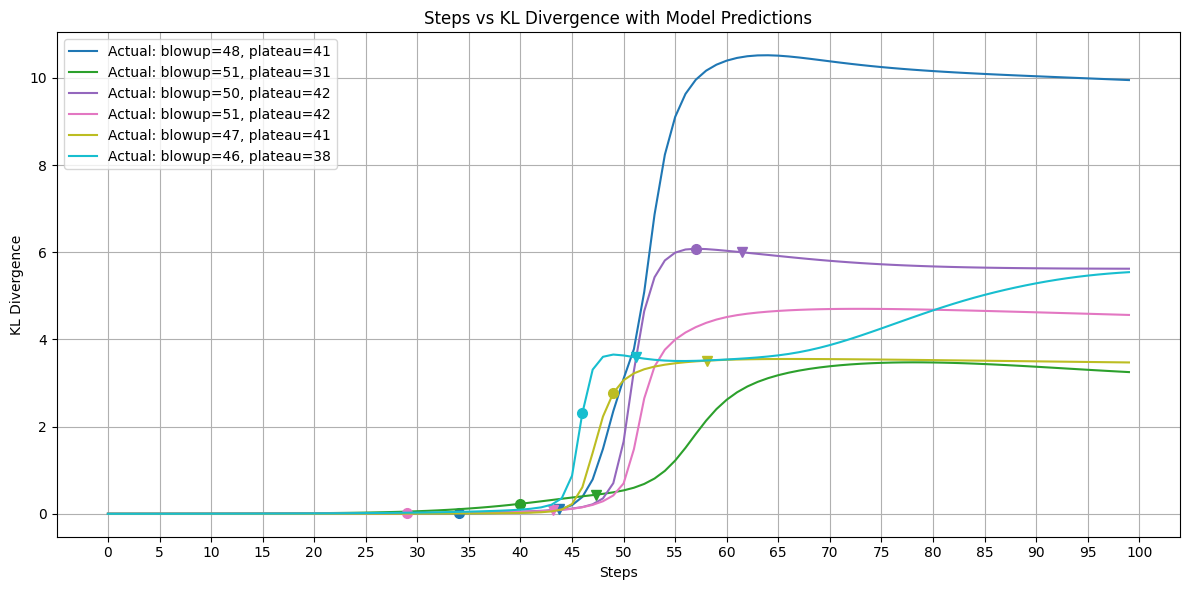

In [40]:
plot_kl_divergence(obs_idxs, df, raw_observations, preds, steps, cmap="tab10")